# Pipeline to set multi-phenomena xr.Datasets for writing to Zarr

In [1]:
import iris
import os
import xarray as xr
import numpy as np

In [2]:
def pp_to_cube(filename, filepath, constraints={}):
    # Load a cube from a .pp file
    cube, = iris.load(os.path.join(filepath, filename), iris.AttributeConstraint(**constraints))
    print(f'Cube loaded from {filename}')
    return cube

In [3]:
def cube_to_xr(cube):
    # Convert Iris cube to Xarray Dataset
    return xr.DataArray.from_iris(cube).to_dataset()

In [4]:
def xr_to_zarr(dataset, zarr_store, chunks={'time':10, 'grid_latitude':219, 'grid_longitude':286}, append_dim='time'):
    # Write dataset to new zarr store
    # OR append dataset to an existing zarr store
    dataset = dataset.chunk(chunks=chunks)
    if os.path.isdir(zarr_store):
        dataset.to_zarr(zarr_store, consolidated=True, append_dim=append_dim)
        print(f'Appended cube to {zarr_store}')
    else:
        dataset.to_zarr(zarr_store, mode='w', consolidated=True)
        print(f'Written cube to {zarr_store}')

In [5]:
def datetimes_from_cube(cube):
    return xr.DataArray.from_iris(cube).time.data

def datetimes_from_zarr(zarr_store):
    return xr.open_zarr(zarr_store).time.data

## Load one .pp file, pull out multiple phenomena, make one Dataset

In [6]:
# Variables for loading data
filepath = '/data/cssp-china/mini-dataset-24-01-19/20CR/daily'
files = sorted(os.listdir(filepath))

STASH_TEMP = 'm01s16i203'
STASH_PRECIP = 'm01s05i216'
STASH_UWIND = 'm01s03i225'
STASH_VWIND = 'm01s03i226'

In [7]:
cubes = iris.load(os.path.join(filepath, files[1]))
cubes

[<iris 'Cube' of m01s05i217 / (unknown) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of air_temperature / (K) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of air_temperature / (K) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of air_temperature / (K) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of air_temperature / (K) (time: 10; pressure: 14; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of cloud_area_fraction / (1) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of geopotential_height / (m) (time: 10; pressure: 14; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of relative_humidity / (%) (time: 10; grid_latitude: 219; grid_longitude: 286)>,
<iris 'Cube' of r

In [28]:
cubes.extract(iris.AttributeConstraint(STASH = STASH_TEMP))

[<iris 'Cube' of air_temperature / (K) (time: 10; pressure: 14; grid_latitude: 219; grid_longitude: 286)>]

In [29]:
cubes.extract(iris.AttributeConstraint(STASH = STASH_PRECIP))

[<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 10; grid_latitude: 219; grid_longitude: 286)>]

In [30]:
cubes.extract(iris.AttributeConstraint(STASH = STASH_UWIND))

[<iris 'Cube' of x_wind / (m s-1) (time: 10; grid_latitude: 218; grid_longitude: 286)>]

In [31]:
cubes.extract(iris.AttributeConstraint(STASH = STASH_VWIND))

[<iris 'Cube' of y_wind / (m s-1) (time: 10; grid_latitude: 218; grid_longitude: 286)>]

In [8]:
cube_t, = cubes.extract(iris.AttributeConstraint(STASH = STASH_TEMP))
cube_p, = cubes.extract(iris.AttributeConstraint(STASH = STASH_PRECIP))
cube_u, = cubes.extract(iris.AttributeConstraint(STASH = STASH_UWIND))
cube_v, = cubes.extract(iris.AttributeConstraint(STASH = STASH_VWIND))

# cubelist = iris.cube.CubeList([cube_t, cube_p, cube_u, cube_v])

In [ ]:
cubelist

In [42]:
ds_list = [cube_to_xr(cube) for cube in cubelist]
ds = xr.merge(ds_list)

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/dask/array/core.py:3855: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs


In [43]:
ds

<xarray.Dataset>
Dimensions:                  (grid_latitude: 437, grid_longitude: 572, pressure: 14, time: 10)
Coordinates:
  * grid_latitude            (grid_latitude) float64 -25.08 -24.97 ... 22.88
  * grid_longitude           (grid_longitude) float64 323.5 323.6 ... 386.3
  * time                     (time) datetime64[ns] 1851-01-05T12:00:00 ... 1851-01-14T12:00:00
  * pressure                 (pressure) float32 10.0 50.0 100.0 ... 925.0 1000.0
    forecast_reference_time  datetime64[ns] 1849-12-01
    forecast_period          (time) timedelta64[ns] 400 days 12:00:00 ... 409 days 12:00:00
    height                   float64 10.0
Data variables:
    air_temperature          (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 1, 437, 572), meta=np.ndarray>
    precipitation_flux       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 437, 572), meta=np.ndarray>
    x_wind                   (time, grid_latitude, grid_longitude) float

In [81]:
ds.y_wind.data.compute()

array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,  2.5029297 ,         nan, ..., -5.0683594 ,
                 nan, -5.0683594 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan, -3.399414  ,         nan, ..., -1.8779297 ,
                 nan, -1.8779297 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,  1.4765625 ,         nan, ..., -3.6357422 ,
                 nan, -3.6357422 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [47]:
da_list = [xr.DataArray.from_iris(cube) for cube in cubelist]
ds_ = xr.merge(da_list)
ds_

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/dask/array/core.py:3855: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs


<xarray.Dataset>
Dimensions:                  (grid_latitude: 437, grid_longitude: 572, pressure: 14, time: 10)
Coordinates:
  * grid_latitude            (grid_latitude) float64 -25.08 -24.97 ... 22.88
  * grid_longitude           (grid_longitude) float64 323.5 323.6 ... 386.3
  * time                     (time) datetime64[ns] 1851-01-05T12:00:00 ... 1851-01-14T12:00:00
  * pressure                 (pressure) float32 10.0 50.0 100.0 ... 925.0 1000.0
    forecast_reference_time  datetime64[ns] 1849-12-01
    forecast_period          (time) timedelta64[ns] 400 days 12:00:00 ... 409 days 12:00:00
    height                   float64 10.0
Data variables:
    air_temperature          (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 1, 437, 572), meta=np.ndarray>
    precipitation_flux       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 437, 572), meta=np.ndarray>
    x_wind                   (time, grid_latitude, grid_longitude) float

In [49]:
ds_.x_wind.data.compute()

array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan, -5.484375  ,         nan, ..., -1.3212891 ,
                 nan, -1.3212891 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,  1.9941406 ,         nan, ...,  3.4873047 ,
                 nan,  3.4873047 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan, -6.131836  ,         nan, ...,  2.0751953 ,
                 nan,  2.0751953 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [51]:
ds_.precipitation_flux.data.compute()

array([[[0.0000000e+00,           nan, 0.0000000e+00, ...,
                   nan, 0.0000000e+00,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [3.4183049e-05,           nan, 2.9238454e-05, ...,
                   nan, 5.7143745e-07,           nan],
        ...,
        [3.3518436e-04,           nan, 3.5878492e-04, ...,
                   nan, 3.4338835e-04,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [0.0000000e+00,           nan, 0.0000000e+00, ...,
                   nan, 0.0000000e+00,           nan]],

       [[0.0000000e+00,           nan, 0.0000000e+00, ...,
                   nan, 0.0000000e+00,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [3.4140621e-07,           nan, 0.0000000e+00, ...,
              

In [53]:
zarr_store = '../zarr_xarray_multiphenom'
xr_to_zarr(ds_, zarr_store)

Written cube to ../zarr_xarray_multiphenom


In [54]:
ds_z = xr.open_zarr(zarr_store)
ds_z

<xarray.Dataset>
Dimensions:                  (grid_latitude: 437, grid_longitude: 572, pressure: 14, time: 10)
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(10,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...
  * grid_latitude            (grid_latitude) float32 -25.08 -24.969997 ... 22.88
  * grid_longitude           (grid_longitude) float32 323.48 ... 386.29004
    height                   float64 ...
  * pressure                 (pressure) float32 10.0 50.0 100.0 ... 925.0 1000.0
  * time                     (time) datetime64[ns] 1851-01-05T12:00:00 ... 1851-01-14T12:00:00
Data variables:
    air_temperature          (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(10, 1, 219, 286), meta=np.ndarray>
    precipitation_flux       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(10, 219, 286), meta=np.ndarray>
    x_wind                   (time, grid_latitude, grid_longitude) flo

In [59]:
cube_x_z = ds_z.x_wind.to_iris()
cube_x_z.data

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, -5.484375, --, ..., -1.3212890625, --, -1.3212890625],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, 1.994140625, --, ..., 3.4873046875, --, 3.4873046875],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, -6.1318359375, --, ..., 2.0751953125, --, 2.0751953125],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, 1.482421875, --, ..., -0.619140625, --, -0.619140625],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, -7.7412109375, --, ..., 4.8388671875, --, 4.8388671875],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, 0.6552734375, --, ..., 2.3408203125, --, 2.3408203125],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ...

### CONCLUSION
1. Merging xr.DataArrays with different grids results in sparse arrays on common grid
2. If this is not desired behaviour, we can filter out data on different grids and save to seperate zarr groups
3. Despite the interleaving, the zarr can be written, read by Xarray (NaN data) and converted to Iris cube (masked data)

# NEXT: Non-interleaving grids

In [66]:
filepath_nc = '/data/cssp-china/sample-data-17-01-20/cssp_china_nc/'
filename_nc = 'apepda.pa526i0.nc'
STASH_UNKNOWN = 'm01s03i289'
cube_unknown = pp_to_cube(filename_nc, filepath_nc, constraints={'STASH': STASH_UNKNOWN})
cube_unknown

Cube loaded from apepda.pa526i0.nc


<iris 'Cube' of m01s03i289 / (1) (pseudo_level: 5; time: 10; grid_latitude: 219; grid_longitude: 286)>

In [67]:
da_unk = xr.DataArray.from_iris(cube_unknown)
ds_unk = xr.merge([ds_, da_unk])
ds_unk

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/dask/array/core.py:3855: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs


<xarray.Dataset>
Dimensions:                  (grid_latitude: 437, grid_longitude: 572, pressure: 14, pseudo_level_0: 5, time: 20)
Coordinates:
  * grid_latitude            (grid_latitude) float64 -25.08 -24.97 ... 22.88
  * grid_longitude           (grid_longitude) float64 323.5 323.6 ... 386.3
  * time                     (time) datetime64[ns] 1851-01-05T12:00:00 ... 1852-06-17T12:00:00
  * pressure                 (pressure) float32 10.0 50.0 100.0 ... 925.0 1000.0
    forecast_reference_time  datetime64[ns] 1849-12-01
    forecast_period          (time) timedelta64[ns] 400 days 12:00:00 ... 929 days 12:00:00
    height                   float64 10.0
  * pseudo_level_0           (pseudo_level_0) int32 1 2 3 4 5
Data variables:
    air_temperature          (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 1, 437, 572), meta=np.ndarray>
    precipitation_flux       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 437, 572), meta=np.

In [70]:
ds_unk.m01s03i289.data.compute()

array([[[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, .

### This gnarly cube is still on one of the two grids so can still be interleaved

# NEXT 2.0: What happens if we add something like UKV data?

In [71]:
filepath_ukv = '/data/project-data-ukv/pmsl/'
filename_ukv = 'pmsl_ukv_20171201.nc'
cubes_ukv = iris.load(os.path.join(filepath_ukv, filename_ukv))
cubes_ukv

[<iris 'Cube' of air_pressure_at_sea_level / (Pa) (forecast_period: 6; forecast_reference_time: 4; grid_latitude: 810; grid_longitude: 621)>]

In [72]:
da_ukv = xr.DataArray.from_iris(cubes_ukv[0])
da_ukv

<xarray.DataArray 'air_pressure_at_sea_level' (forecast_period: 6, forecast_reference_time: 4, grid_latitude: 810, grid_longitude: 621)>
dask.array<filled, shape=(6, 4, 810, 621), dtype=float32, chunksize=(6, 4, 810, 621), chunktype=numpy.ndarray>
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 05:00:00
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2017-12-01T03:00:00 ... 2017-12-01T21:00:00
  * grid_latitude            (grid_latitude) float32 -3.7707 -3.7572 ... 7.1508
  * grid_longitude           (grid_longitude) float64 354.9 354.9 ... 363.3
    time                     (forecast_reference_time, forecast_period) datetime64[ns] ...
Attributes:
    standard_name:  air_pressure_at_sea_level
    units:          Pa
    source:         Data from Met Office Unified Model
    um_version:     10.6
    Conventions:    CF-1.5
    STASH:          m01s16i222

In [73]:
ds_disgusting = xr.merge([ds_unk, da_ukv])
ds_disgusting

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/dask/array/core.py:3855: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs


<xarray.Dataset>
Dimensions:                    (forecast_period: 6, forecast_reference_time: 4, grid_latitude: 1247, grid_longitude: 1193, pressure: 14, pseudo_level_0: 5, time: 20)
Coordinates:
  * grid_latitude              (grid_latitude) float64 -25.08 -24.97 ... 22.88
  * grid_longitude             (grid_longitude) float64 323.5 323.6 ... 386.3
  * time                       (time) datetime64[ns] 1851-01-05T12:00:00 ... 1852-06-17T12:00:00
  * pressure                   (pressure) float32 10.0 50.0 ... 925.0 1000.0
  * forecast_reference_time    (forecast_reference_time) datetime64[ns] 2017-12-01T03:00:00 ... 2017-12-01T21:00:00
  * forecast_period            (forecast_period) timedelta64[ns] 00:00:00 ... 05:00:00
    height                     float64 10.0
  * pseudo_level_0             (pseudo_level_0) int32 1 2 3 4 5
Data variables:
    air_temperature            (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 1, 1247, 1193), meta=np.ndarray>
 

In [74]:
ds_disgusting.air_pressure_at_sea_level

<xarray.DataArray 'air_pressure_at_sea_level' (forecast_period: 6, forecast_reference_time: 4, grid_latitude: 1247, grid_longitude: 1193)>
dask.array<where, shape=(6, 4, 1247, 1193), dtype=float32, chunksize=(6, 4, 1247, 1193), chunktype=numpy.ndarray>
Coordinates:
  * grid_latitude            (grid_latitude) float64 -25.08 -24.97 ... 22.88
  * grid_longitude           (grid_longitude) float64 323.5 323.6 ... 386.3
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2017-12-01T03:00:00 ... 2017-12-01T21:00:00
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 05:00:00
    height                   float64 10.0
Attributes:
    standard_name:  air_pressure_at_sea_level
    units:          Pa
    source:         Data from Met Office Unified Model
    um_version:     10.6
    Conventions:    CF-1.5
    STASH:          m01s16i222

In [75]:
ds_disgusting.air_pressure_at_sea_level[1, 1, :, :]

<xarray.DataArray 'air_pressure_at_sea_level' (grid_latitude: 1247, grid_longitude: 1193)>
dask.array<getitem, shape=(1247, 1193), dtype=float32, chunksize=(1247, 1193), chunktype=numpy.ndarray>
Coordinates:
  * grid_latitude            (grid_latitude) float64 -25.08 -24.97 ... 22.88
  * grid_longitude           (grid_longitude) float64 323.5 323.6 ... 386.3
    forecast_reference_time  datetime64[ns] 2017-12-01T09:00:00
    forecast_period          timedelta64[ns] 01:00:00
    height                   float64 10.0
Attributes:
    standard_name:  air_pressure_at_sea_level
    units:          Pa
    source:         Data from Met Office Unified Model
    um_version:     10.6
    Conventions:    CF-1.5
    STASH:          m01s16i222

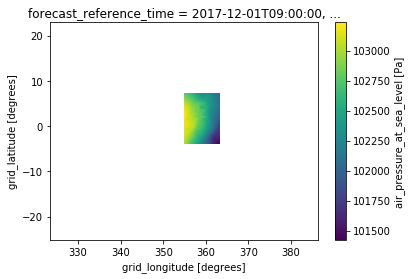

In [78]:
%matplotlib inline
ds_disgusting.air_pressure_at_sea_level[1, 1, :, :].plot()

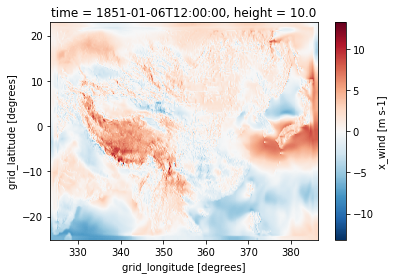

In [80]:
ds_disgusting.x_wind[1].plot()